In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
from qiskit import QuantumCircuit, Aer, assemble

In [3]:
from math import pi
from qiskit.visualization import array_to_latex

# Agenda for today:
1. Background: (15 mins)
    1. Global phase and why it can’t be measured (1 mins)
    2. Phase Kickback (4 mins)
    3. Quantum Fourier transform (5 mins)
    4. Quantum Phase Estimation (5 mins)
2. Period finding problems and quantum solutions (25 mins)
    1. Deutsch-Jozsa Algorithm (and, briefly, Bernstein-Vazirani Algorithm) (8 mins)
    2. Simon’s Algorithm (8 mins)
    3. Discrete Log and Shor’s Algorithm (9 mins)
3. Summary of period finding algorithms and why quantum computer is good at this (10 mins)

## 1.1 Global Phase
If unitary $U$ acts on quantum state $|\psi\rangle$ such that
$$
U|\psi\rangle = e^{i\phi}|\psi\rangle, 0 \le \phi \le 2\pi
$$
then $U$ adds global phase $e^{i\phi}$ on this quantum state.

Recall in linear algebra that if for matrix $A$ there's a vector $v$ s.t.
$$
Av = \lambda v
$$
then $v$ is an eigenvector of $A$ and $\lambda$ is the corresponding eigenvalue. Also recall that eigenvectors are defined up to a constant, which is saying $v' = \alpha v$ is the same eigenvector as $v$. In the same spirit, we cannot tell $e^{i\phi}|\psi\rangle$ apart from quantum state $|\psi\rangle$ and thus the global phase cannot be observed.

## 1.2 Phase Kickback
Recall P-gate
$$
P(\phi) = \begin{bmatrix}
1 & 0\\
0 & e^{i\phi}
\end{bmatrix}, \phi\in\mathbb{R}
$$
We can define a controlled P-gate as
$$
CP(\phi) = \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 &e^{i\phi}
\end{bmatrix}, \phi\in\mathbb{R}
$$
This applies a P-gate if the control qubit is $|1\rangle$ and no effect otherwise.

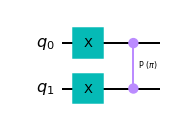

In [18]:
qc_cp = QuantumCircuit(2)
qc_cp.x(0)
qc_cp.x(1)
qc_cp.cp(pi, 0, 1)
qc_cp.draw()

In [19]:
svsim = Aer.get_backend("aer_simulator")
qc_cp.save_statevector()
qobj = assemble(qc_cp)
final_state = svsim.run(qobj).result().get_statevector()
array_to_latex(final_state, prefix="\\text{Final state} = ")

<IPython.core.display.Latex object>

As one would expect, the end state is
$$
CP(\theta)|11\rangle = \begin{bmatrix}
0\\
0\\
0\\
e^{i\pi}
\end{bmatrix}
$$

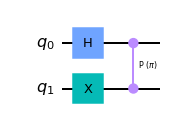

In [12]:
qc_kb = QuantumCircuit(2)
qc_kb.h(0)
qc_kb.x(1)
qc_kb.cp(pi, 0, 1)
qc_kb.draw()

In [13]:
qc_kb.save_statevector()
qobj = assemble(qc_kb)
final_state = svsim.run(qobj).result().get_statevector()
array_to_latex(final_state, prefix="\\text{Final state} = ")

<IPython.core.display.Latex object>

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


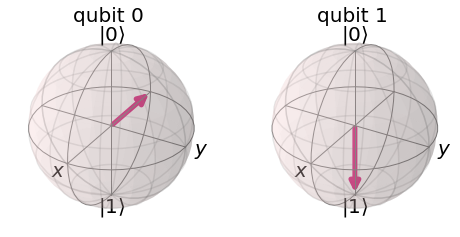

In [14]:
plot_bloch_multivector(final_state)

When we put the control qubit in equal superposition, however, we see the gate actually added a relative phase of $\pi$. This is surprising but makes sense: when we applied this gate earlier on $|11\rangle$, we see it added a global phase to the state because $|1\rangle$ is an eigenstate of this gate; but when we put qubit 0 in $\{|+\rangle, |-\rangle\}$ basis, it's no longer in an eigenstate of P-gate, and the relative phase caused it to rotate by $\pi$ around the Z axis. This will be very useful in our following discussions.

## 1.3 Quantum Fourier transform
Recall the classical discrete Fourier transform transforms a complex vector $X = \begin{bmatrix}
x_1\\
x_2\\
\vdots\\
x_n
\end{bmatrix}
$ into another complex vector $Y = \begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_n
\end{bmatrix}
$ where
$$
y_k = \sum^{n-1}_{j=0}x_j{e^{-\frac{2\pi{i}}{n}jk}}
$$
An example use of DFT is to transform time series data from time domain to frequency domain

Similarly, assume we have an $n$-qubit system and $N = 2^n$, we define QFT to be a transformation from $|X\rangle = \sum^{N-1}_{j=0}x_j|j\rangle$ to $|Y\rangle = \sum^{N-1}_{k=0}y_k|k\rangle$ where
$$
y_k = \frac{1}{\sqrt{N}}\sum^{N-1}_{j=0}x_j{e^{\frac{2\pi{i}}{N}jk}}
$$
With a little effort, one can show that this implies
$$
QFT|x\rangle = \frac{1}{\sqrt{N}}\sum^{N-1}_{y=0}{e^{\frac{2\pi{i}}{N}xy}}|y\rangle, \forall 0 \le x < N
$$
If we express $y$ in binary, we could get
$$
QFT|x\rangle = \frac{1}{\sqrt{N}}\sum^{N-1}_{y=0}\prod^{n}_{k=1}{e^{\frac{2\pi{i}}{2^k}xy_k}}|y_1 y_2 \dots y_n\rangle
$$
If we write this all out, it would look something like
$$
\begin{align*}
QFT|x\rangle = \frac{1}{\sqrt{N}}\big[ & \left(|0\rangle\otimes|0\rangle\otimes\dots\otimes|0\rangle\right)\\
& + \left( \exp(\frac{2\pi{i}x}{2^n}) \right)\left(|0\rangle\otimes|0\rangle\otimes\dots\otimes|1\rangle\right)\\
& + \left( \exp(\frac{2\pi{i}x}{2^{n-1}}) \right)\left(|0\rangle\otimes|0\rangle\otimes\dots\otimes|1\rangle\otimes|0\rangle\right)\\
& + \left( \exp(\frac{2\pi{i}x}{2^n})\exp(\frac{2\pi{i}x}{2^{n-1}}) \right)\left(|0\rangle\otimes|0\rangle\otimes\dots\otimes|1\rangle\otimes|1\rangle\right)\\
& + \dots\\
& + \left( \prod^{n}_{k=1}\exp(\frac{2\pi{i}x}{2^k}) \right)\left(|1\rangle\otimes|1\rangle\otimes\dots\otimes|1\rangle\right)\big]
\end{align*}
$$
If we rearrange the constants, it would look something like
$$
\begin{align*}
QFT|x\rangle = \frac{1}{\sqrt{N}}\big[ & \left(|0\rangle\otimes|0\rangle\otimes\dots\otimes|0\rangle\right)\\
& + \left(|0\rangle\otimes|0\rangle\otimes\dots\otimes\left( \exp(\frac{2\pi{i}x}{2^n}) |1\rangle \right)\right)\\
& + \left(|0\rangle\otimes|0\rangle\otimes\dots\otimes\left( \exp(\frac{2\pi{i}x}{2^{n-1}}) |1\rangle\right)\otimes|0\rangle\right)\\
& + \left(|0\rangle\otimes|0\rangle\otimes\dots\otimes\left( \exp(\frac{2\pi{i}x}{2^{n-1}}) |1\rangle\right)\otimes \left( \exp(\frac{2\pi{i}x}{2^{n}})|1\rangle \right)\right)\\
& + \dots\\
& + \left( \left( \exp(\frac{2\pi{i}x}{2})|1\rangle \right) \otimes \left( \exp(\frac{2\pi{i}x}{2^2})|1\rangle \right) \otimes \dots \otimes \left( \exp(\frac{2\pi{i}x}{2^n})|1\rangle \right)\right)\big]
\end{align*}
$$
Since
$$
\left( a + b \right) \otimes \left( c + d \right) = a \otimes c + b \otimes c + a \otimes d + b \otimes d
$$
We can rewrite
$$
\begin{align*}
QFT|x\rangle = \frac{1}{\sqrt{N}}
& \left( |0\rangle + \exp(\frac{2\pi ix}{2^1}|1\rangle \right)\\
& \otimes \left( |0\rangle + \exp(\frac{2\pi ix}{2^2}|1\rangle \right)\\
& \otimes \dots\\
& \otimes \left( |0\rangle + \exp(\frac{2\pi ix}{2^n}|1\rangle \right)
\end{align*}
$$
So we see that what QFT really is doing is that it takes in a "binary" representation of an integer and translate it into the Fourier basis. It is also clear that we need to leverage phase kickback to implement QFT.

## 1.4 Quantum Phase Estimation
As aforementioned, a global phase is not observable. So suppose we have unitary $U$ that gives $|\psi\rangle$ a global phase $2\pi i\theta$ ($0\le\theta\le 1$), how do we find $\theta$? Remember we just mentioned that QFT translates a number expressed in "binary" into Fourier basis. Since $QFT$ is a unitary transformation, $QFT\dagger$ must translate the same number from Fourier basis back to "binary". So if we can somehow represent $\theta$ in Fourier basis, then we can use $QFT\dagger$ to get $\theta$. Looking at the last equation for QFT above, we see that to represent $x$ in Fourier basis, we simply need to add a relative phase of $\exp(\frac{2\pi ix}{2^k})$ to the $k_{th}$ qubit, and we can use phase kickback to achieve exactly that.

## 2.1a Deutsch-Jozsa Algorithm

## 2.1b Berstein-Vazirani Algorithm

## 2.2 Simon's Algorithm

## 2.3a Discrete Log Problem and its quantum solution

## 2.3b Shor's Algorithm

# Summary: Period finding algorithms and why quantum computer is a good fit
As we can see, all those algorithms boils down to finding some periodicity. In the case of Deutsch-Jozsa, we are in essence trying to find if the period of function $f(x)$ is 1 (the constant case). In all of those algorithms, we follow the procedure of encoding the period in the qubits using phase kickback and use some form of reversed QFT to recover the period.

So why are quantum computers good at finding period efficiently? (My conjecture is that) Because in the classical realm, we don't have a powerful enough medium to store information about the period/frequency, that's why we can only recover the period by sampling many data points generated from the distribution. In quantum realm, however, we can directly encode that period in the phase. Through phase kickback, we can represent that phase in Fourier basis and recover it. Actually now that I think of it, it makes some sense to encode period in phase because $2\pi\omega$ in phase is like the frequency.

Note when to use QFT vs Hadamard? Hadamard $H^{\otimes n}$ essentially is QFT that acts on $\mathbb{Z}^{n}_{2}$, whereas $QFT_{n}$ acts on domain $\mathbb{Z}_{2^n}$. So when both $H^{\otimes n}$ and $QFT_{n}$ sees the $k_{th}$ qubit $|\psi\rangle$ ($\psi \in \{0, 1\}$), $H^{\otimes n}$ treats it as just a $\psi$, whereas $QFT_{n}$ treats it as $2^{k-1}\psi$. This is why we see the Hadamards being used in those early algorithms that are used to solve problems that has to do with $mod\ 2$